# Predictive Maintenance

## Customize Enviornment

In [2]:
# load packages
packages <- c("purrr", "doMC", "RMySQL", "lubridate", "ggplot2", "caret", "DMwR", "pROC")
purrr::walk(packages, library, character.only = TRUE, warn.conflicts = FALSE)

# set default plot size
options(repr.plot.width=10, repr.plot.height=6)

# configure multicore processing
registerDoMC(cores=8)

## Load Data

In [3]:
# create an open connection to the database
#cn <- dbConnect(drv = RMySQL::MySQL(),
#                host = "host",
#                port = 3306,
#                user = "user",
#                password = "password",
#                dbname = "db")

# query the database and store the results into a DataFrame
#df <- dbGetQuery(cn, "SELECT * FROM dryer3_1_hour_before_fail")
#dbDisconnect(cn)

In [6]:
# save df to local machine
#saveRDS(df, "dryer3_1_hour_before_fail.Rda")
df_all <- readRDS("dryer3_1_hour_before_fail.Rda")

In [7]:
# remove rows without complete data
nrow(df_all)
df <- df_all[complete.cases(df_all),]
nrow(df)

[1] 11312

[1] 11311

In [8]:
# create a new variable that indicates failure in the next hour
df$Class  <- as.factor(df$FAIL)

# drop the old failure indicators
df$FAIL <- NULL

# create variable names for the Class variable
levels(df$Class) <- make.names(c("notFail", "fail"))

In [9]:
# create new variables for dates and time
df$Datetime_hour <- ymd_hms(df$Datetime)
df$Year <- year(df$Datetime_hour)
df$Month <- month(df$Datetime_hour)
df$Day <- day(df$Datetime_hour)
df$Hour <- hour(df$Datetime_hour)
df$Minute <- minute(df$Datetime_hour)
df$Datetime_hour <- as.factor(df$Datetime_hour)

In [10]:
# look at the number of variables
cat("Number of variables before:")
ncol(df)

# drop variables are are constant
df <- df[sapply(df, function(x) length(unique(na.omit(x)))) > 1]
    
# look at the number of variables
cat("\nNumber of variables after:")
ncol(df)

Number of variables before:

[1] 216


Number of variables after:

[1] 200

In [11]:
# split data into traning and test
set.seed(1234)
trainIndex <- createDataPartition(df$Class, 
                                  p = .6, 
                                  list = FALSE, 
                                  times = 1)

imbal_train <- df[ trainIndex,]
non_train   <- df[-trainIndex,]

trainIndex <- createDataPartition(non_train$Class, 
                                  p = .5, 
                                  list = FALSE, 
                                  times = 1)

imbal_test  <- non_train[ trainIndex,]
imbal_valid <- non_train[-trainIndex,]

In [12]:
# seperate datetime_hour from each dataset so that I can join it up late
train_dt <- imbal_train$Datetime_hour
imbal_train$Datetime_hour <- NULL

test_dt <- imbal_test$Datetime_hour
imbal_test$Datetime_hour <- NULL

valid_dt <- imbal_valid$Datetime_hour
imbal_valid$Datetime_hour <- NULL

In [14]:
set.seed(1234)
smote_train <- SMOTE(Class ~ ., 
                     data = imbal_train, 
                     perc.over = 1000)                         

cat("Number of events by type in the original dataset:")
table(imbal_train$Class)

cat("\nNumber of events by type in the balanced dataset:")
table(smote_train$Class)

Number of events by type in the original dataset:


notFail    fail 
   6741      47 


Number of events by type in the balanced dataset:


notFail    fail 
    940     517 

In [15]:
# use k-fold cross validation 
fitControl <- trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 1,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary)

In [17]:
# fit bagged classification and maximize ROC
set.seed(1234)
treebag_fit <- train(Class ~ ., 
                     data = smote_train,
                     method = "treebag",
                     nbagg = 50,
                     metric = "ROC",
                     preProc = c("range"),
                     trControl = fitControl,
                     na.action = na.exclude)

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“No variation for for: TempSet4_min, TempSet4_std, TempSet4_mean, TempSet2_mean, TempSet2_std, TempSet2_min, TempSet3_min, TempSet3_mean, TempSet3_std, TempSet1_std, TempSet6_mean, TempSet6_std, TempSet6_min, TempSet5_mean, TempSet5_std, TempSet5_min”

In [18]:
# review model fit
treebag_fit

Bagged CART 

1457 samples
 198 predictor
   2 classes: 'notFail', 'fail' 

Pre-processing: re-scaling to [0, 1] (182) 
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 1165, 1166, 1165, 1166, 1166 
Resampling results:

  ROC        Sens       Spec     
  0.9682127  0.9776596  0.8839806

 

In [21]:
# use model to predict training data
treebag_train <- predict(treebag_fit, imbal_train, type = "prob")
treebag_train$pred <- factor(ifelse(treebag_train$fail >= .50, "fail", "notFail"))
treebag_train <- cbind(treebag_train, actual = imbal_train$Class)
confusionMatrix(data = treebag_train$pred, reference = treebag_train$actual, positive = 'fail')

Warning message in confusionMatrix.default(data = treebag_train$pred, reference = treebag_train$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notFail fail
   notFail    6627    0
   fail        114   47
                                          
               Accuracy : 0.9832          
                 95% CI : (0.9799, 0.9861)
    No Information Rate : 0.9931          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.446           
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.000000        
            Specificity : 0.983089        
         Pos Pred Value : 0.291925        
         Neg Pred Value : 1.000000        
             Prevalence : 0.006924        
         Detection Rate : 0.006924        
   Detection Prevalence : 0.023718        
      Balanced Accuracy : 0.991544        
                                          
       'Positive' Class : fail            
                                          

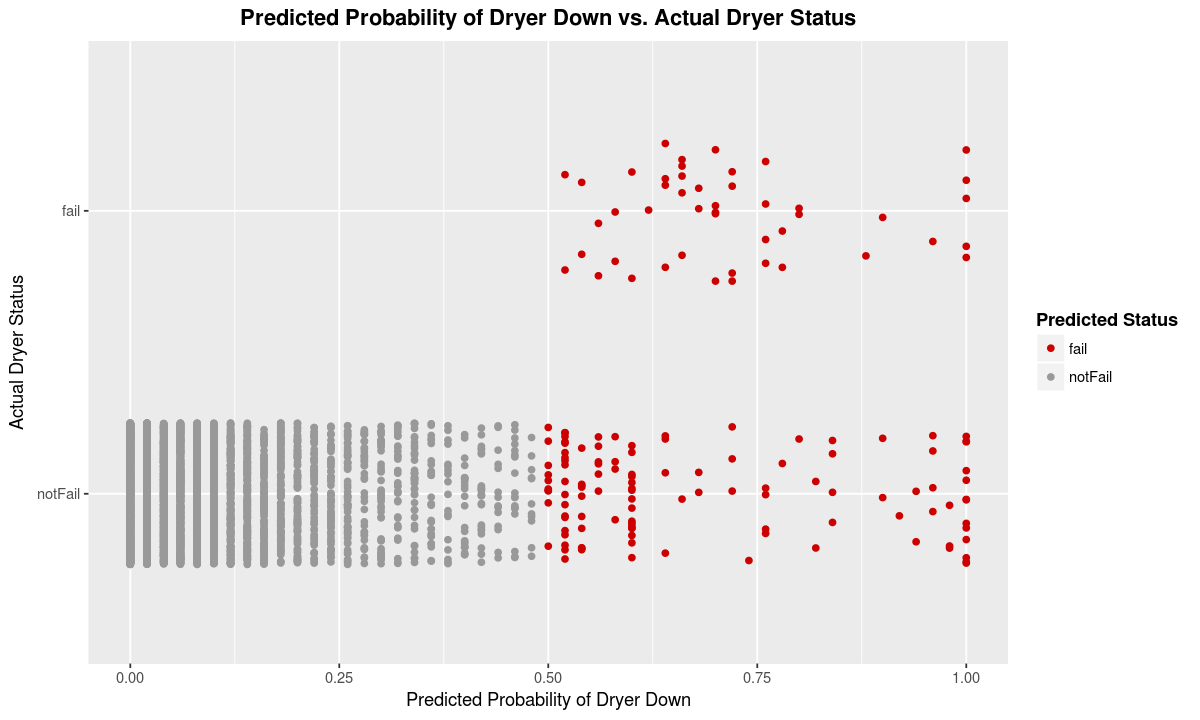

In [23]:
# plot the posterior probability vs actual
ggplot(data = treebag_train) +
  geom_point(mapping = aes(x = fail, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#CC0000", "#999999"))

In [24]:
# use model to predict test data
treebag_test <- predict(treebag_fit, imbal_test, type = "prob")
treebag_test$pred <- factor(ifelse(treebag_test$fail >= .50, "fail", "notFail"))
treebag_test <- cbind(treebag_test, actual = imbal_test$Class)
confusionMatrix(data = treebag_test$pred, reference = treebag_test$actual, positive = 'fail')

Warning message in confusionMatrix.default(data = treebag_test$pred, reference = treebag_test$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notFail fail
   notFail    2204   14
   fail         43    1
                                          
               Accuracy : 0.9748          
                 95% CI : (0.9675, 0.9809)
    No Information Rate : 0.9934          
    P-Value [Acc > NIR] : 1.0000000       
                                          
                  Kappa : 0.0242          
 Mcnemar's Test P-Value : 0.0002083       
                                          
            Sensitivity : 0.0666667       
            Specificity : 0.9808634       
         Pos Pred Value : 0.0227273       
         Neg Pred Value : 0.9936880       
             Prevalence : 0.0066313       
         Detection Rate : 0.0004421       
   Detection Prevalence : 0.0194518       
      Balanced Accuracy : 0.5237650       
                                          
       'Positive' Class : fail            
                                          

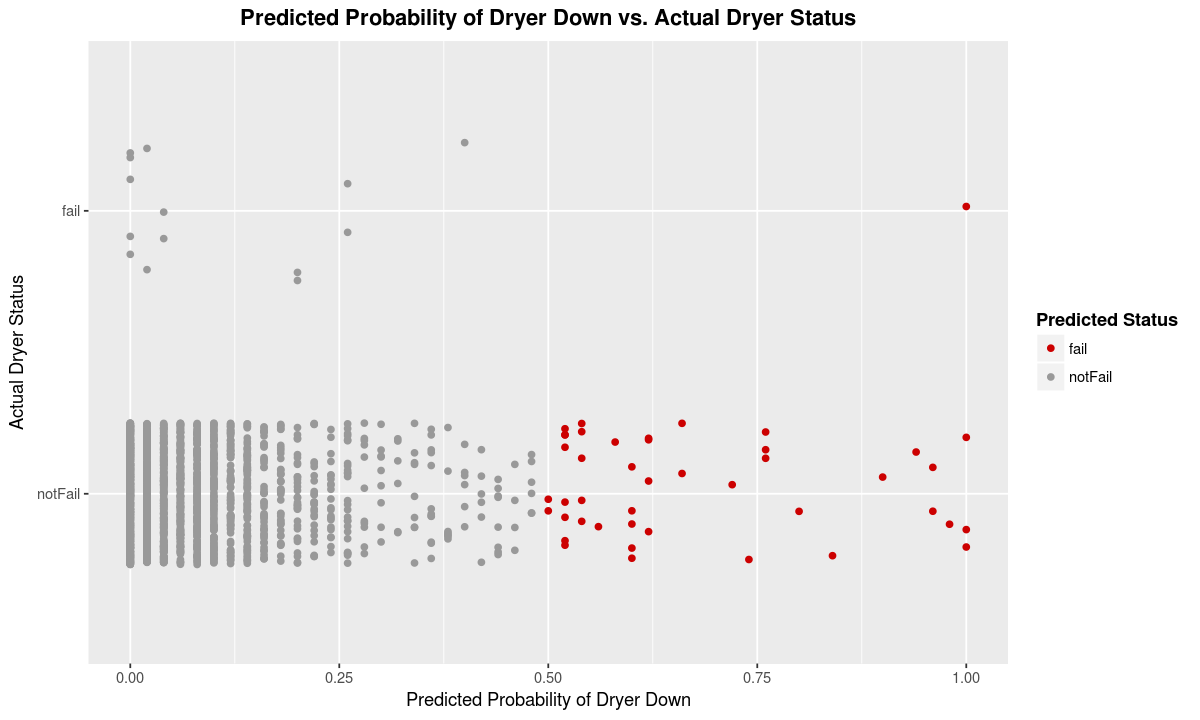

In [25]:
# plot the posterior probability vs actual
ggplot(data = treebag_test) +
  geom_point(mapping = aes(x = fail, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#CC0000", "#999999"))

In [26]:
# use model to predict validation data
treebag_valid <- predict(treebag_fit, imbal_valid, type = "prob")
treebag_valid$pred <- factor(ifelse(treebag_valid$fail >= .50, "fail", "notFail"))
treebag_valid <- cbind(treebag_valid, actual = imbal_valid$Class)
confusionMatrix(data = treebag_valid$pred, reference = treebag_valid$actual, positive = 'fail')

Warning message in confusionMatrix.default(data = treebag_valid$pred, reference = treebag_valid$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notFail fail
   notFail    2197   15
   fail         49    0
                                         
               Accuracy : 0.9717         
                 95% CI : (0.964, 0.9781)
    No Information Rate : 0.9934         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : -0.0103        
 Mcnemar's Test P-Value : 3.707e-05      
                                         
            Sensitivity : 0.000000       
            Specificity : 0.978183       
         Pos Pred Value : 0.000000       
         Neg Pred Value : 0.993219       
             Prevalence : 0.006634       
         Detection Rate : 0.000000       
   Detection Prevalence : 0.021672       
      Balanced Accuracy : 0.489092       
                                         
       'Positive' Class : fail           
                                         

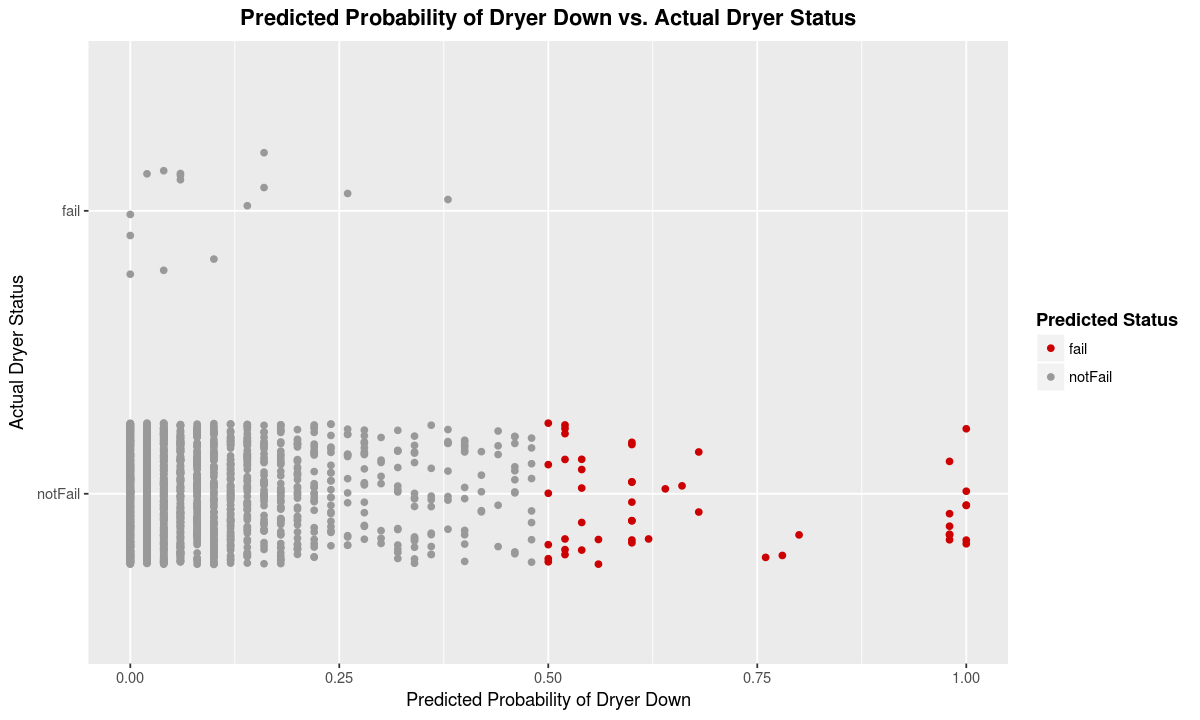

In [27]:
# plot the posterior probability vs actual
ggplot(data = treebag_valid) +
  geom_point(mapping = aes(x = fail, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#CC0000", "#999999"))

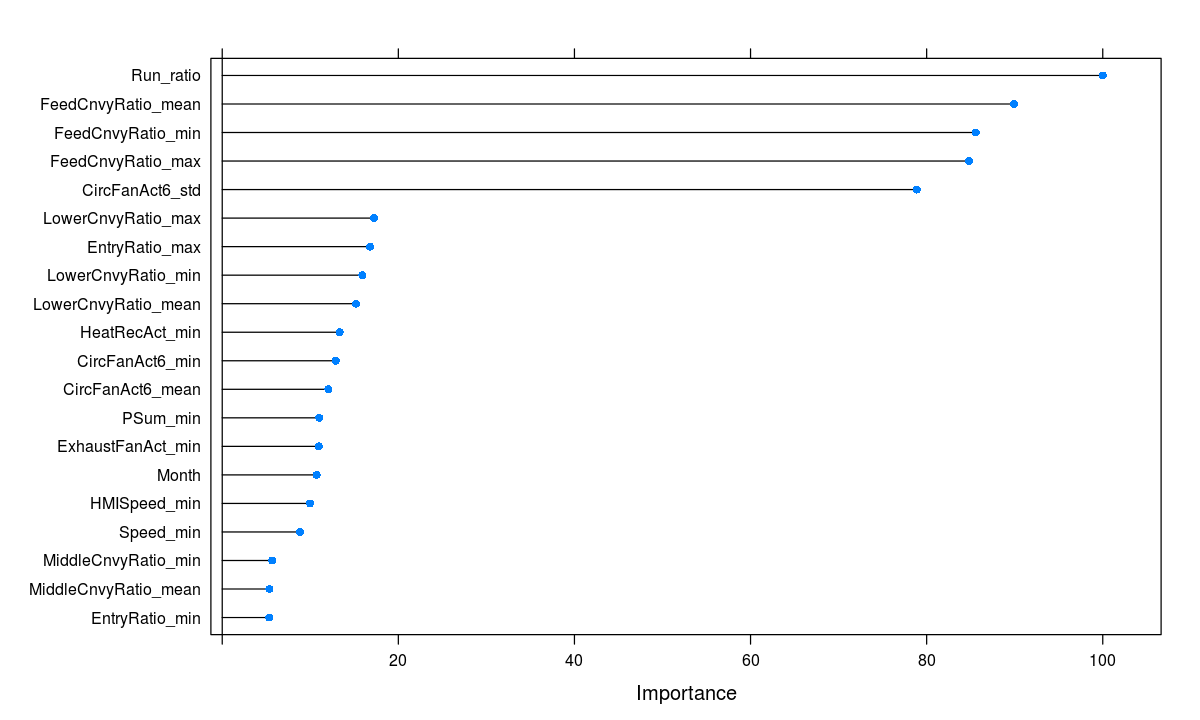

In [29]:
# plot variable importance
plot(varImp(treebag_fit), top=20)

In [41]:
# fit cost-sensitive model to all combinations of parameters specified in grid and choose model with the highest ROC
set.seed(1234)
svm_fit <- train(Class ~ ., 
                 data = smote_train,
                 method = "svmRadialWeights",
                 metric = "ROC",
                 preProc = c("range"),
                 tuneGrid = expand.grid(C = c(1:20),
                                        sigma = c(0.05),
                                        Weight = c(1)),
                 trControl = fitControl,
                 na.action = na.exclude)

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“No variation for for: TempSet4_min, TempSet4_std, TempSet4_mean, TempSet2_mean, TempSet2_std, TempSet2_min, TempSet3_min, TempSet3_mean, TempSet3_std, TempSet1_std, TempSet6_mean, TempSet6_std, TempSet6_min, TempSet5_mean, TempSet5_std, TempSet5_min”Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”

In [42]:
# review model fit
svm_fit

Support Vector Machines with Class Weights 

1457 samples
 198 predictor
   2 classes: 'notFail', 'fail' 

Pre-processing: re-scaling to [0, 1] (182) 
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 1165, 1166, 1165, 1166, 1166 
Resampling results across tuning parameters:

  C   ROC        Sens       Spec     
   1  0.9424695  0.9553191  0.7834951
   2  0.9559830  0.9606383  0.8221247
   3  0.9618709  0.9627660  0.8414302
   4  0.9653765  0.9659574  0.8530433
   5  0.9678595  0.9680851  0.8607916
   6  0.9695495  0.9702128  0.8627334
   7  0.9707740  0.9702128  0.8685026
   8  0.9721329  0.9744681  0.8723674
   9  0.9728221  0.9744681  0.8743092
  10  0.9737057  0.9744681  0.8781927
  11  0.9741684  0.9712766  0.8820575
  12  0.9748883  0.9702128  0.8820388
  13  0.9754639  0.9702128  0.8820388
  14  0.9760393  0.9702128  0.8820202
  15  0.9765529  0.9691489  0.8820202
  16  0.9769112  0.9702128  0.8820202
  17  0.9774553  0.9702128  0.8839619
  18  0.

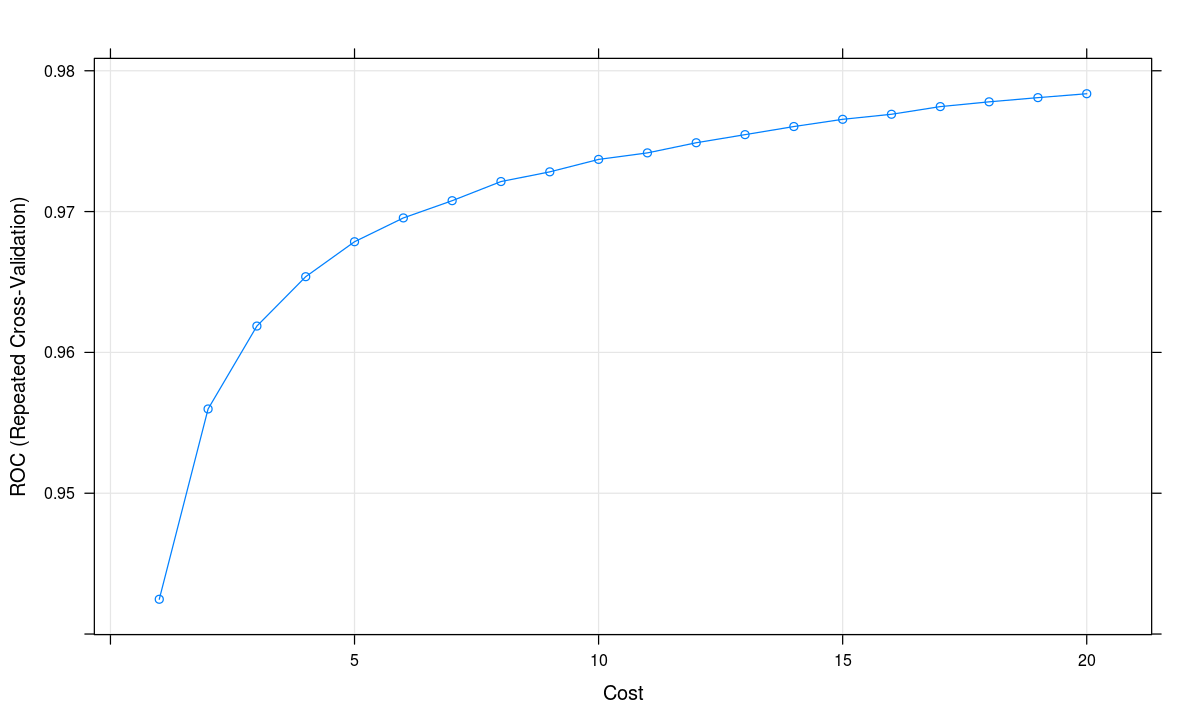

In [43]:
# plot ROC over all levels of C
plot(svm_fit)

In [44]:
# use model to predict training data
svm_train <- predict(svm_fit, imbal_train, type = "prob")
svm_train$pred <- factor(ifelse(svm_train$fail >= .50, "fail", "notFail"))
svm_train <- cbind(svm_train, actual = imbal_train$Class)
confusionMatrix(data = svm_train$pred, reference = svm_train$actual, positive = 'fail')

Warning message in confusionMatrix.default(data = svm_train$pred, reference = svm_train$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notFail fail
   notFail    6656   24
   fail         85   23
                                          
               Accuracy : 0.9839          
                 95% CI : (0.9807, 0.9868)
    No Information Rate : 0.9931          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2899          
 Mcnemar's Test P-Value : 9.086e-09       
                                          
            Sensitivity : 0.489362        
            Specificity : 0.987391        
         Pos Pred Value : 0.212963        
         Neg Pred Value : 0.996407        
             Prevalence : 0.006924        
         Detection Rate : 0.003388        
   Detection Prevalence : 0.015910        
      Balanced Accuracy : 0.738376        
                                          
       'Positive' Class : fail            
                                          

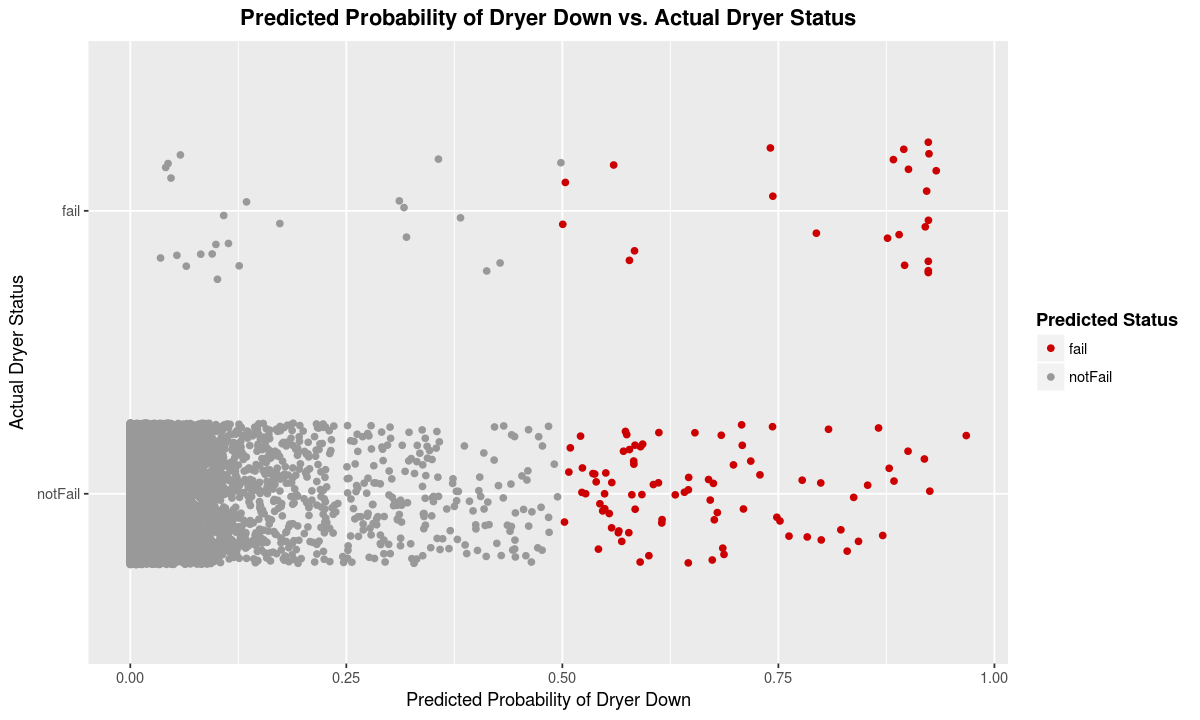

In [45]:
# plot the posterior probability vs actual
ggplot(data = svm_train) +
  geom_point(mapping = aes(x = fail, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#CC0000", "#999999"))

In [49]:
# use model to predict test data
svm_test <- predict(svm_fit, imbal_test, type = "prob")
svm_test$pred <- factor(ifelse(svm_test$fail >= 0.50, "fail", "notFail"))
svm_test <- cbind(svm_test, actual = imbal_test$Class)
confusionMatrix(data = svm_test$pred, reference = svm_test$actual, positive = 'fail')

Warning message in confusionMatrix.default(data = svm_test$pred, reference = svm_test$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notFail fail
   notFail    2215   13
   fail         32    2
                                          
               Accuracy : 0.9801          
                 95% CI : (0.9735, 0.9855)
    No Information Rate : 0.9934          
    P-Value [Acc > NIR] : 1.00000         
                                          
                  Kappa : 0.0731          
 Mcnemar's Test P-Value : 0.00729         
                                          
            Sensitivity : 0.1333333       
            Specificity : 0.9857588       
         Pos Pred Value : 0.0588235       
         Neg Pred Value : 0.9941652       
             Prevalence : 0.0066313       
         Detection Rate : 0.0008842       
   Detection Prevalence : 0.0150309       
      Balanced Accuracy : 0.5595461       
                                          
       'Positive' Class : fail            
                                          

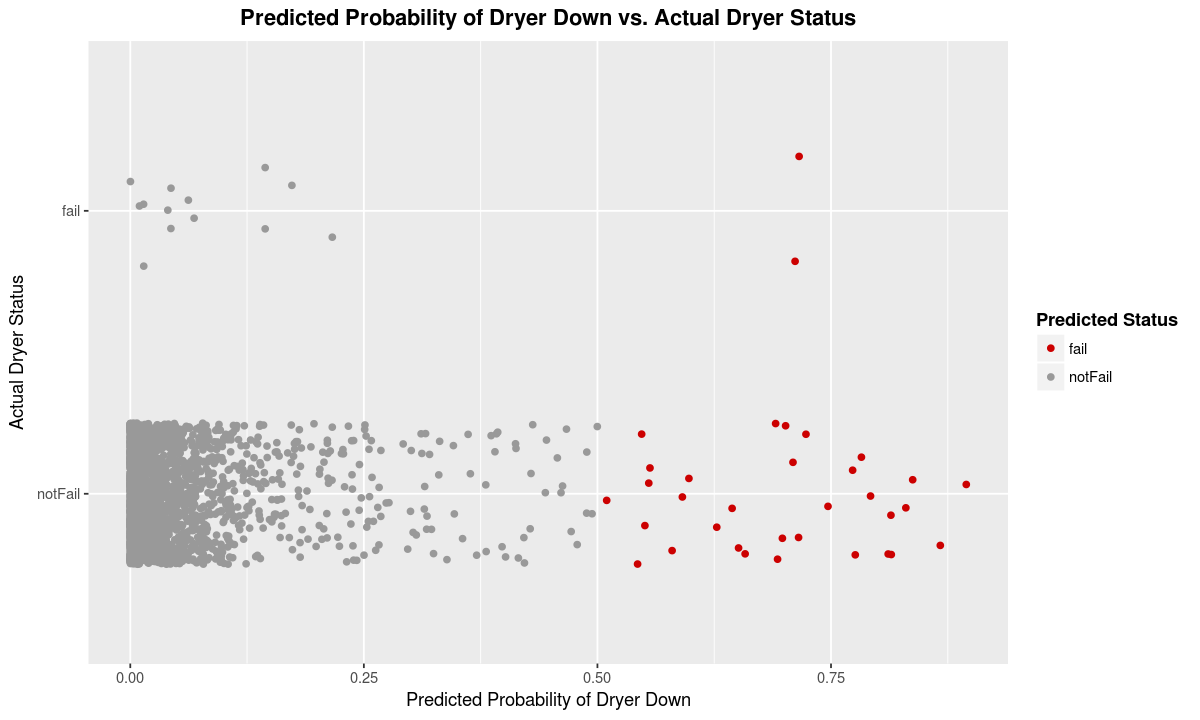

In [50]:
# plot the posterior probability vs actual
ggplot(data = svm_test) +
  geom_point(mapping = aes(x = fail, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#CC0000", "#999999"))

In [51]:
# use model to predict validation data
svm_valid <- predict(svm_fit, imbal_valid, type = "prob")
svm_valid$pred <- factor(ifelse(svm_valid$fail >= 0.50, "fail", "notFail"))
svm_valid <- cbind(svm_valid, actual = imbal_valid$Class)
confusionMatrix(data = svm_valid$pred, reference = svm_valid$actual, positive = 'fail')

Warning message in confusionMatrix.default(data = svm_valid$pred, reference = svm_valid$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notFail fail
   notFail    2212   14
   fail         34    1
                                         
               Accuracy : 0.9788         
                 95% CI : (0.972, 0.9843)
    No Information Rate : 0.9934         
    P-Value [Acc > NIR] : 1.000000       
                                         
                  Kappa : 0.031          
 Mcnemar's Test P-Value : 0.006099       
                                         
            Sensitivity : 0.0666667      
            Specificity : 0.9848620      
         Pos Pred Value : 0.0285714      
         Neg Pred Value : 0.9937107      
             Prevalence : 0.0066342      
         Detection Rate : 0.0004423      
   Detection Prevalence : 0.0154799      
      Balanced Accuracy : 0.5257643      
                                         
       'Positive' Class : fail           
                                         

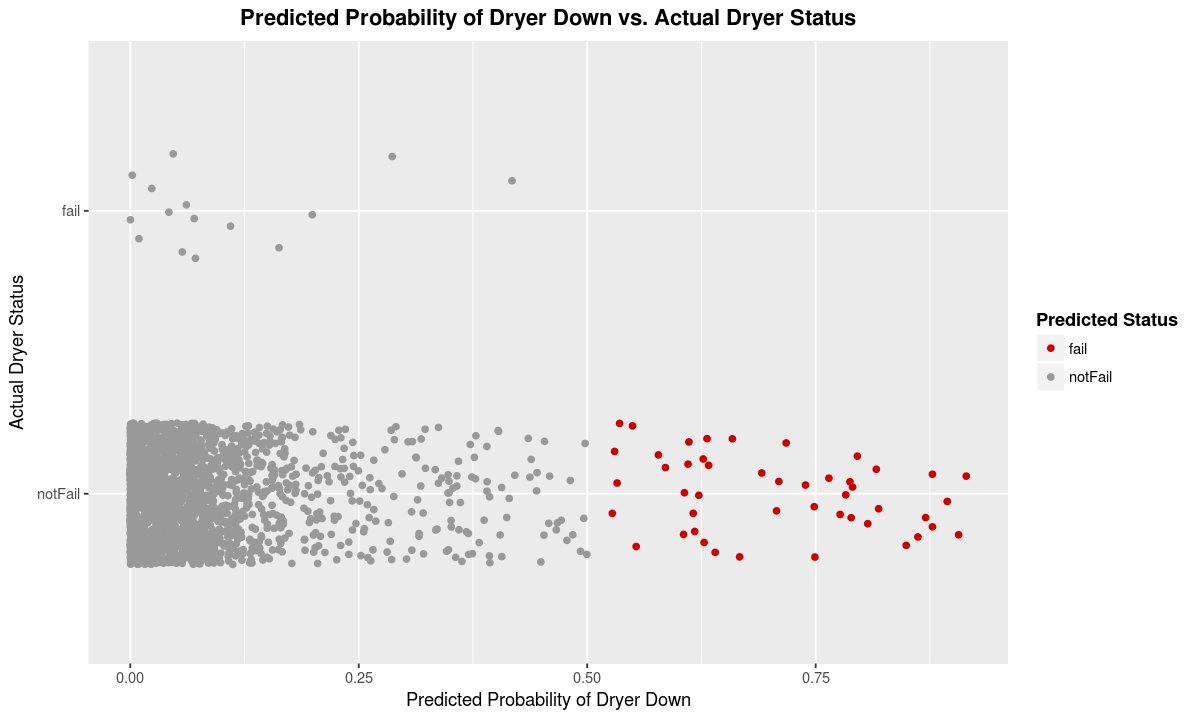

In [39]:
# plot the posterior probability vs actual
ggplot(data = svm_valid) +
  geom_point(mapping = aes(x = fail, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#CC0000", "#999999"))

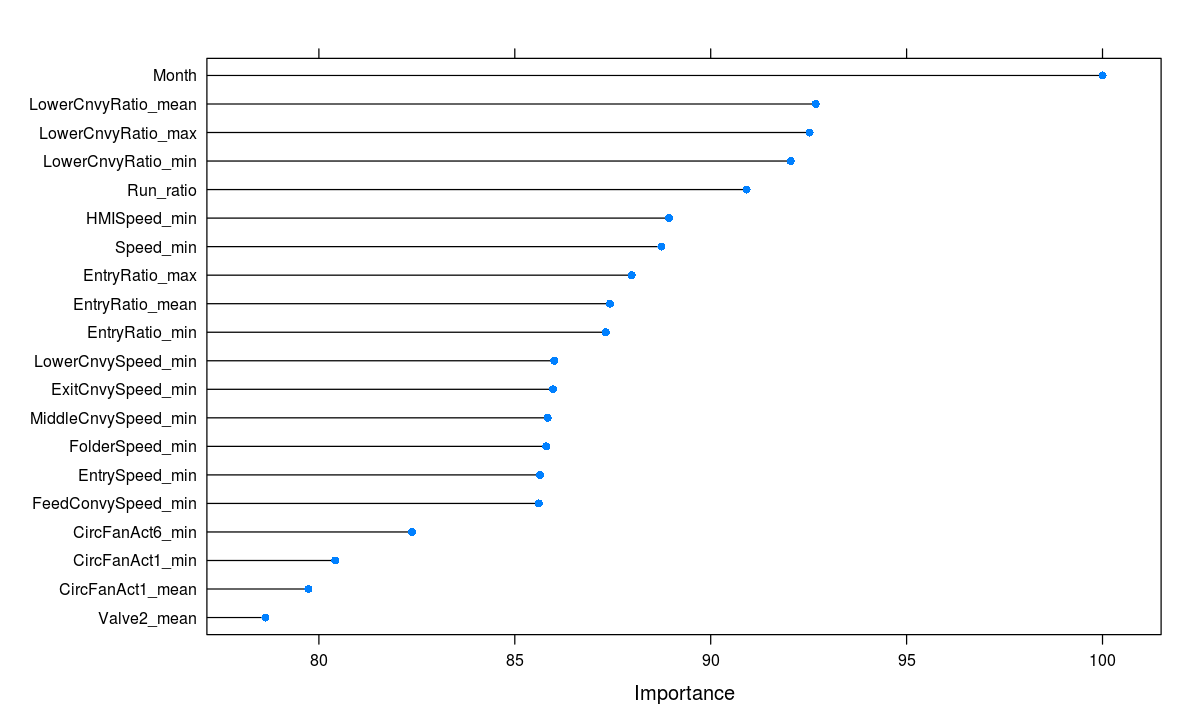

In [40]:
plot(varImp(svm_fit), top=20)

In [ ]:
df